          feature         VIF
0            step    2.450367
1            type    3.701953
2          amount    2.490283
3  oldbalanceorig  719.851341
4  newbalanceorig  733.099689
5  oldbalancedest   81.842702
6  newbalancedest   87.132199
Type of transaction which are fraud: ['TRANSFER', 'CASH_OUT']
Number of transfers that are fraud: 1417
Number of cashouts that are fraud: 1436
Minimum amount transfer where isFlaggedFraud is 1: 1343002.08
Maximum amount transfer where isFlaggedFraud is 0: 10000000.0
Number of isFlaggedFraud == 1: 2
Number of recipient transactions where newbalancedest and oldbalancedest are zero: 1193626
Number of transactions where oldbalanceorig & newbalanceorig is zero but amount is not zero: 1086863
Number of merchants in originator transaction: False
Number of merchant accounts in destination where type is Transfer: False
Number of merchant accounts in destination where type is Cashout: False
2853
1445159
AUPRC = 0.9822018505137896
Accuracy = 0.9993819124801884


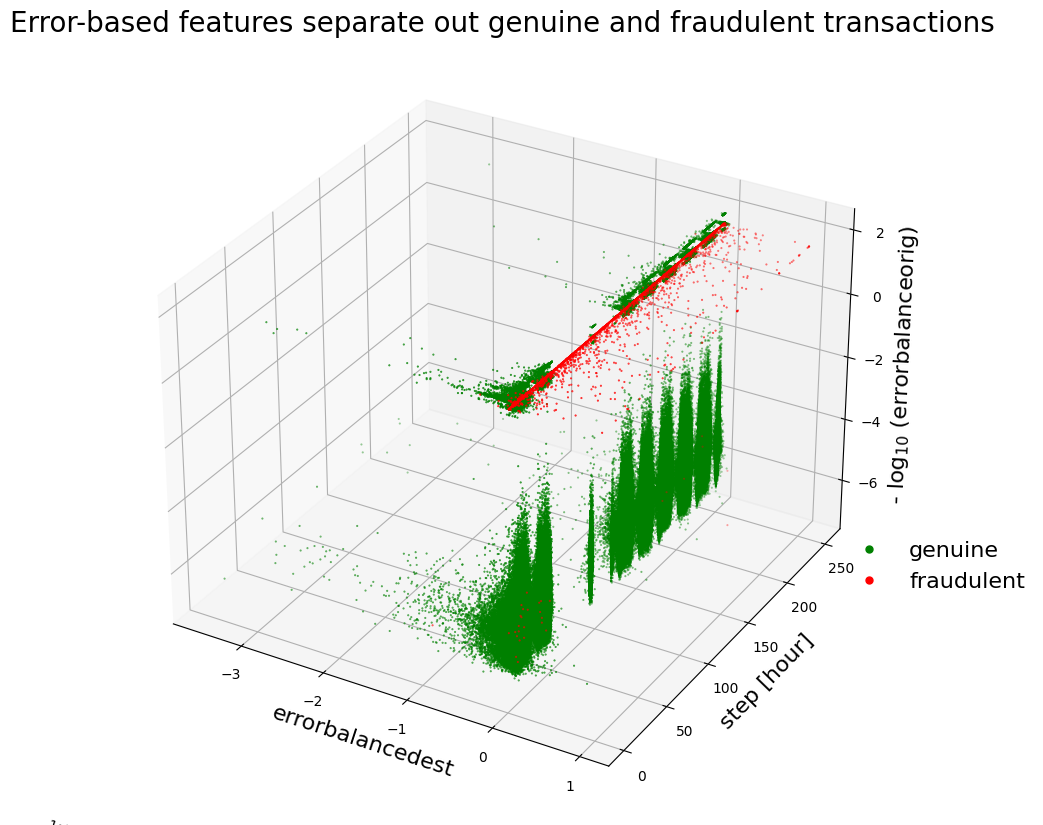

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, accuracy_score
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Loading the dataset
df = pd.read_csv('Fraud.csv')

# Renaming columns for consistency
df = df.rename(columns={'nameOrig':'nameorig','oldbalanceOrg':'oldbalanceorig','newbalanceOrig':'newbalanceorig',
                        'nameDest':'namedest','oldbalanceDest':'oldbalancedest','newbalanceDest':'newbalancedest'})

# Checking for missing values
df.isnull().sum()

# Creating a copy of the dataset for VIF and modeling
df1 = df.copy(deep=True)

# Mapping transaction types to numerical values
df1['type'] = df1['type'].map({'PAYMENT': 1, 'TRANSFER': 2, 'CASH_OUT': 3, 'DEBIT': 4, 'CASH_IN': 5})

# Dropping unnecessary columns
df1 = df1.drop(columns=['nameorig', 'namedest', 'isFraud', 'isFlaggedFraud'])

# Handling missing or infinite values in df1 for VIF calculation
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(inplace=True)

# Calculating VIF to check for multicollinearity between variables
vif_data = pd.DataFrame()
vif_data["feature"] = df1.columns
vif_data["VIF"] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]

# Displaying the VIF values
print(vif_data)

# Exploring the fraud data
print('Type of transaction which are fraud: {}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

fraud_transfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
fraud_cashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('Number of transfers that are fraud: {}'.format(len(fraud_transfer)))
print('Number of cashouts that are fraud: {}'.format(len(fraud_cashout)))

# Analyzing flagged frauds
amount_flagfraud0 = list(df.loc[(df.isFlaggedFraud == 0)].amount.values)
amount_flagfraud1 = list(df.loc[(df.isFlaggedFraud == 1)].amount.values)

# Check for empty sequence before applying min/max
if amount_flagfraud1:
    print('Minimum amount transfer where isFlaggedFraud is 1: {}'.format(min(amount_flagfraud1)))
else:
    print('No transactions where isFlaggedFraud is 1.')

if amount_flagfraud0:
    print('Maximum amount transfer where isFlaggedFraud is 0: {}'.format(max(amount_flagfraud0)))
else:
    print('No transactions where isFlaggedFraud is 0.')

print('Number of isFlaggedFraud == 1: {}'.format(len(df.loc[df.isFlaggedFraud == 1])))

# Transactions where both old and new balances are zero
print('Number of recipient transactions where newbalancedest and oldbalancedest are zero: {}'.format(
    len(df.loc[(df.newbalancedest == 0) & (df.oldbalancedest == 0)].namedest.values)))

zero_balance = list(df.loc[(df.oldbalanceorig == 0) & (df.newbalanceorig == 0) & (df.amount != 0)].type.values)
print('Number of transactions where oldbalanceorig & newbalanceorig is zero but amount is not zero: {}'.format(len(zero_balance)))

# Merchant-related transactions
print('Number of merchants in originator transaction: {}'.format(df.nameorig.str.contains('M').any()))
print('Number of merchant accounts in destination where type is Transfer: {}'.format(df.loc[df.type == 'TRANSFER'].namedest.str.contains('M').any()))
print('Number of merchant accounts in destination where type is Cashout: {}'.format(df.loc[df.type == 'CASH_OUT'].namedest.str.contains('M').any()))

# Prepare data for XGBoost model
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
y = x.isFraud
x = x.drop(['isFraud', 'isFlaggedFraud', 'nameorig', 'namedest'], axis=1)
x['type'] = x['type'].map({'TRANSFER': 1, 'CASH_OUT': 2})

# Handling zero balances
x.loc[(x.oldbalancedest == 0) & (x.newbalancedest == 0) & (x.amount != 0), ['oldbalancedest', 'newbalancedest']] = -1
x.loc[(x.oldbalanceorig == 0) & (x.newbalanceorig == 0) & (x.amount != 0), ['oldbalanceorig', 'newbalanceorig']] = 0

# Imputing missing values
x['errorbalanceorig'] = x.newbalanceorig + x.amount - x.oldbalanceorig
x['errorbalancedest'] = x.oldbalancedest + x.amount - x.newbalancedest

# Removing NaN values from target and feature variables
x.dropna(inplace=True)
y.dropna(inplace=True)

# Ensuring target `y` only contains binary classes (0 and 1)
y = y.astype(int)

# Plotting genuine and fraudulent transactions using 3D scatter plot
x1 = 'errorbalancedest'
y1 = 'step'
z1 = 'errorbalanceorig'
zOffset = 0.02
limit = len(x)

sns.reset_orig()
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x.loc[y == 0, x1][:limit], x.loc[y == 0, y1][:limit], -np.log10(x.loc[y == 0, z1][:limit] + zOffset), c='g', marker='.', s=1, label='genuine')
ax.scatter(x.loc[y == 1, x1][:limit], x.loc[y == 1, y1][:limit], -np.log10(x.loc[y == 1, z1][:limit] + zOffset), c='r', marker='.', s=1, label='fraudulent')

ax.set_xlabel(x1, size=16)
ax.set_ylabel(y1 + ' [hour]', size=16)
ax.set_zlabel('- log$_{10}$ (' + z1 + ')', size=16)
ax.set_title('Error-based features separate out genuine and fraudulent transactions', size=20)

plt.axis('tight')
ax.grid(1)

# Adding legend
noFraudMarker = mlines.Line2D([], [], linewidth=0, color='g', marker='.', markersize=10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth=0, color='r', marker='.', markersize=10, label='fraudulent')
plt.legend(handles=[noFraudMarker, fraudMarker], bbox_to_anchor=(1.20, 0.38), frameon=False, prop={'size': 16})

# Checking counts of fraudulent and non-fraudulent transactions
xfraud = x.loc[y == 1]
xnotfraud = x.loc[y == 0]
print(len(xfraud))
print(len(xnotfraud))

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=27)

# Handling class imbalance using scale_pos_weight
weights = (y == 0).sum() / (1.0 * (y == 1).sum())

# Building and training the XGBoost classifier
clf = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4)
clf.fit(X_train, y_train)

# Predicting probabilities and labels
probabilities = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Evaluating the model
print('AUPRC = {}'.format(average_precision_score(y_test, probabilities[:, 1])))

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = {}'.format(accuracy))
